In [152]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series,DataFrame
import numpy as np
import seaborn as sns
import numpy as np
import mplfinance as mpl
from matplotlib import pyplot as plt

import torch
import torch.nn as nn

In [153]:
data=pd.read_csv('HDFCBANK_Data.csv')
data.shape

(7266, 6)

In [154]:
data.head()

,DATE,Open,High,Low,Close,Volume
0,01/01/1996,3.030,3.030,2.925,2.980,350000
1,01/02/1996,2.980,3.025,2.950,2.975,412000
2,01/03/1996,2.975,2.995,2.950,2.985,284000
3,01/04/1996,2.985,2.980,2.940,2.965,282000
4,01/05/1996,2.965,2.980,2.950,2.960,189000


In [155]:
data = data.set_index('DATE')
data

,Open,High,Low,Close,Volume
DATE,,,,,
01/01/1996,3.030000,3.030000,2.925000,2.980000,350000
01/02/1996,2.980000,3.025000,2.950000,2.975000,412000
01/03/1996,2.975000,2.995000,2.950000,2.985000,284000
01/04/1996,2.985000,2.980000,2.940000,2.965000,282000
01/05/1996,2.965000,2.980000,2.950000,2.960000,189000
...,...,...,...,...,...
11/28/2024,1819.000000,1836.099976,1788.000000,1793.150024,17861196
11/29/2024,1801.300049,1804.599976,1782.900024,1796.050049,13834768
12/02/2024,1803.500000,1808.150024,1775.000000,1804.699951,7555438


In [156]:
sel_col = ['Open', 'High', 'Low', 'Close']  
df_main = data[sel_col]
df_main.head()

,Open,High,Low,Close
DATE,,,,
01/01/1996,3.030,3.030,2.925,2.980
01/02/1996,2.980,3.025,2.950,2.975
01/03/1996,2.975,2.995,2.950,2.985
01/04/1996,2.985,2.980,2.940,2.965
01/05/1996,2.965,2.980,2.950,2.960


In [157]:
np.sum(df_main.isnull())


c:\Users\Stewie\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Open     0
High     0
Low      0
Close    0
dtype: int64

In [158]:
import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))  
for col in sel_col:                           
    df_main[col] = scaler.fit_transform(df_main[col].values.reshape(-1,1))

C:\Users\Stewie\AppData\Local\Temp\ipykernel_26100\1471626412.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main[col] = scaler.fit_transform(df_main[col].values.reshape(-1,1))
C:\Users\Stewie\AppData\Local\Temp\ipykernel_26100\1471626412.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main[col] = scaler.fit_transform(df_main[col].values.reshape(-1,1))
C:\Users\Stewie\AppData\Local\Temp\ipykernel_26100\1471626412.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [159]:
df_main.dropna()                     
df_main = df_main.astype(np.float32)

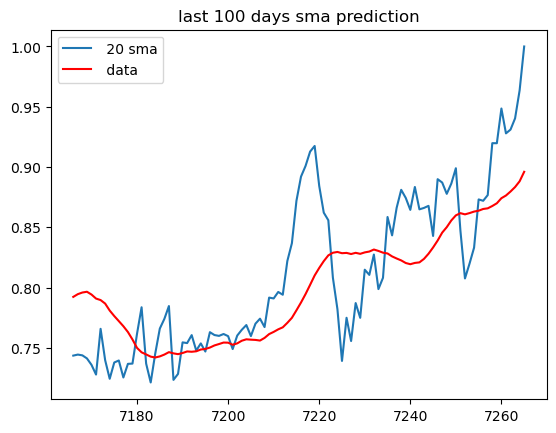

In [160]:

import matplotlib.ticker as ticker
close = df_main['Close']
close = close.reset_index()
close_df = pd.DataFrame(close)

x = close_df.DATE
ticker_spacing = x
ticker_spacing = 50

window = 20
# trail-rolling average transform
rolling = close_df["Close"].rolling(window=window)
rolling_mean = rolling.mean()


plt.plot(close_df['Close'][-100:],label=" 20 sma")
plt.plot(rolling_mean[-100:], 'r',label=" data")
plt.title('last 100 days sma prediction')
plt.legend()

In [161]:
from sklearn.metrics import mean_squared_error, r2_score
#import numpy as np 
print(f"SMA20 MSE：{mean_squared_error(close_df['Close'][21:], rolling_mean[21:])}") # start from the 21th day.

SMA20 MSE：0.0006952455513042879


In [162]:
# build LSTM model

input_dim = 4      
hidden_dim = 32   
num_layers = 1     
output_dim = 1    
                   
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x):
        # Initialize hidden state with zeros   
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out
    
# GRU model
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
#RNN model
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.rnn(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [163]:
def split_data(df_main, seq, validation_size=0.1, test_size=0.2):
    # Create all possible sequences of length seq
    data = []
    for index in range(len(df_main) - seq):
        data.append(df_main[index: index + seq])
    
    data = np.array(data)
    
    # Calculate the sizes for each set
    test_set_size = int(np.round(test_size * data.shape[0]))
    val_set_size = int(np.round(validation_size * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size + val_set_size)
    
    # Split data into train, validation, and test sets
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size+val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size+val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:, :-1, :]
    y_test = data[train_set_size+val_set_size:, -1, :]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]


In [164]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(df_main, seq=30, validation_size=0.1, test_size=0.2)

In [165]:
model_LSTM = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model_GRU = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model_RNN = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

optimiser_LSTM = torch.optim.Adam(model_LSTM.parameters(), lr=0.01) # 使用Adam优化算法
optimiser_GRU = torch.optim.Adam(model_GRU.parameters(), lr=0.01) # 使用Adam优化算法
optimiser_RNN = torch.optim.Adam(model_RNN.parameters(), lr=0.01) # 使用Adam优化算法

loss_fn = torch.nn.MSELoss(reduction='mean') # 使用均方差作为损失函数

In [166]:
# tranfer data as tensor

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)
y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)

## Train model

In [167]:

# train model SMLT
num_epochs = 100

hist_LSTM = np.zeros(num_epochs)
for t in range(num_epochs):
    
    # Forward pass
    y_train_pred1 = model_LSTM(x_train)

    loss = loss_fn(y_train_pred1, y_train_lstm)
    if t % 10 == 0 and t !=0:                  # 每训练十次，打印一次均方差
        print("Epoch ", t, "model_LSTM MSE: ", loss.item())
    hist_LSTM[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs 将梯度归零
    optimiser_LSTM.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    optimiser_LSTM.step()

c:\Users\Stewie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([5065, 4])) that is different to the input size (torch.Size([5065, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  10 model_LSTM MSE:  0.032112233340740204
Epoch  20 model_LSTM MSE:  0.016436152160167694
Epoch  30 model_LSTM MSE:  0.010836133733391762
Epoch  40 model_LSTM MSE:  0.00605548033490777
Epoch  50 model_LSTM MSE:  0.0022338014096021652
Epoch  60 model_LSTM MSE:  0.0004127603315282613
Epoch  70 model_LSTM MSE:  0.0002890430623665452
Epoch  80 model_LSTM MSE:  5.142852387507446e-05
Epoch  90 model_LSTM MSE:  2.9699252991122194e-05


In [168]:
# train model GRU
hist_GRU = np.zeros(num_epochs)
for t in range(num_epochs):
    
    # Forward pass
    y_train_pred2 = model_GRU(x_train)

    loss = loss_fn(y_train_pred2, y_train_gru) ###y_train_gru
    if t % 10 == 0 and t !=0:                  # 每训练十次，打印一次均方差
        print("Epoch ", t, "model_GRU MSE: ", loss.item())
    hist_GRU[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs 将梯度归零
    optimiser_GRU.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    optimiser_GRU.step()

Epoch  10 model_GRU MSE:  0.008082915097475052
Epoch  20 model_GRU MSE:  0.00959088746458292
Epoch  30 model_GRU MSE:  0.006819652859121561
Epoch  40 model_GRU MSE:  0.004848245996981859
Epoch  50 model_GRU MSE:  0.003418863518163562
Epoch  60 model_GRU MSE:  0.002144677797332406
Epoch  70 model_GRU MSE:  0.0013074763119220734
Epoch  80 model_GRU MSE:  0.0007974393083713949
Epoch  90 model_GRU MSE:  0.00035301849129609764


In [169]:
# train model RNN
hist_RNN = np.zeros(num_epochs)
for t in range(num_epochs):
    
    # Forward pass
    y_train_pred3 = model_RNN(x_train)

    loss = loss_fn(y_train_pred3, y_train_rnn) ###y_train_gru
    if t % 10 == 0 and t !=0:                  # 每训练十次，打印一次均方差
        print("Epoch ", t, "model_RNN MSE: ", loss.item())
    hist_RNN[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs 将梯度归零
    optimiser_RNN.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    optimiser_RNN.step()

Epoch  10 model_RNN MSE:  0.04518013447523117
Epoch  20 model_RNN MSE:  0.00706558907404542
Epoch  30 model_RNN MSE:  0.00817240308970213
Epoch  40 model_RNN MSE:  0.004018568899482489
Epoch  50 model_RNN MSE:  0.0015808757161721587
Epoch  60 model_RNN MSE:  0.00027390269679017365
Epoch  70 model_RNN MSE:  0.0003119093889836222
Epoch  80 model_RNN MSE:  0.00010307326738256961
Epoch  90 model_RNN MSE:  4.860600165557116e-05


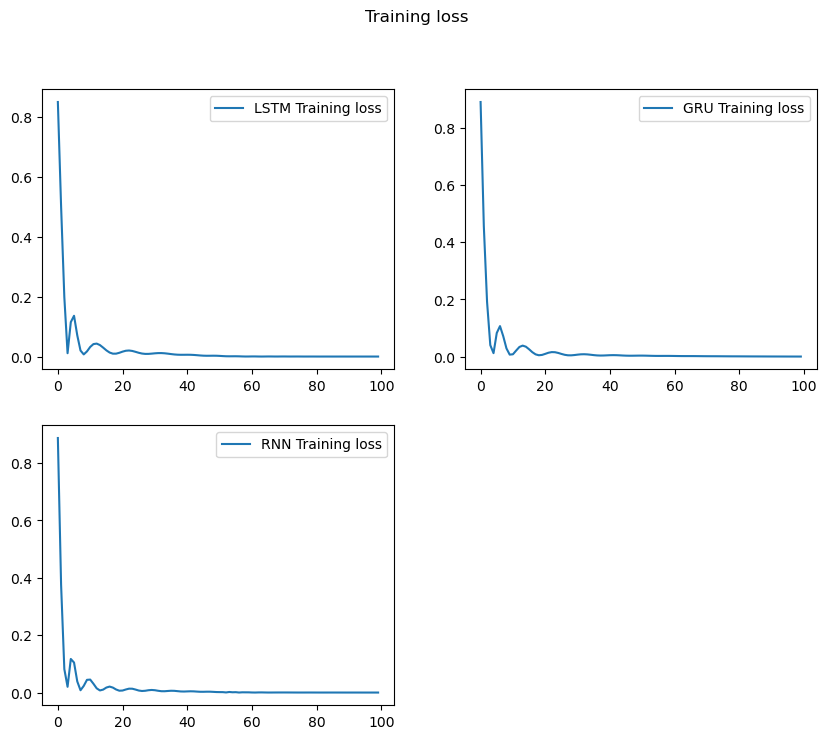

In [170]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(hist_LSTM, label="LSTM Training loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(hist_GRU, label="GRU Training loss")
plt.legend()

plt.subplot(2,2,3)
plt.plot(hist_RNN, label="RNN Training loss")
plt.legend()

plt.suptitle("Training loss")
plt.show()

In [171]:
# make predictions
y_test_pred1 = model_LSTM(x_test)
test_loss_LSTM = loss_fn(y_test_pred1, y_test_lstm).item()

y_test_pred2 = model_GRU(x_test)
test_loss_GRU = loss_fn(y_test_pred2, y_test_gru).item()

y_test_pred3 = model_RNN(x_test)
test_loss_RNN = loss_fn(y_test_pred3, y_test_rnn).item()

print('test loss for LSTM is ',test_loss_LSTM)
print('test loss for GRU is ',test_loss_GRU)
print('test loss for RNN is ',test_loss_RNN)

test loss for LSTM is  0.15631970763206482
test loss for GRU is  0.04999006167054176
test loss for RNN is  0.013454888015985489


c:\Users\Stewie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1447, 4])) that is different to the input size (torch.Size([1447, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


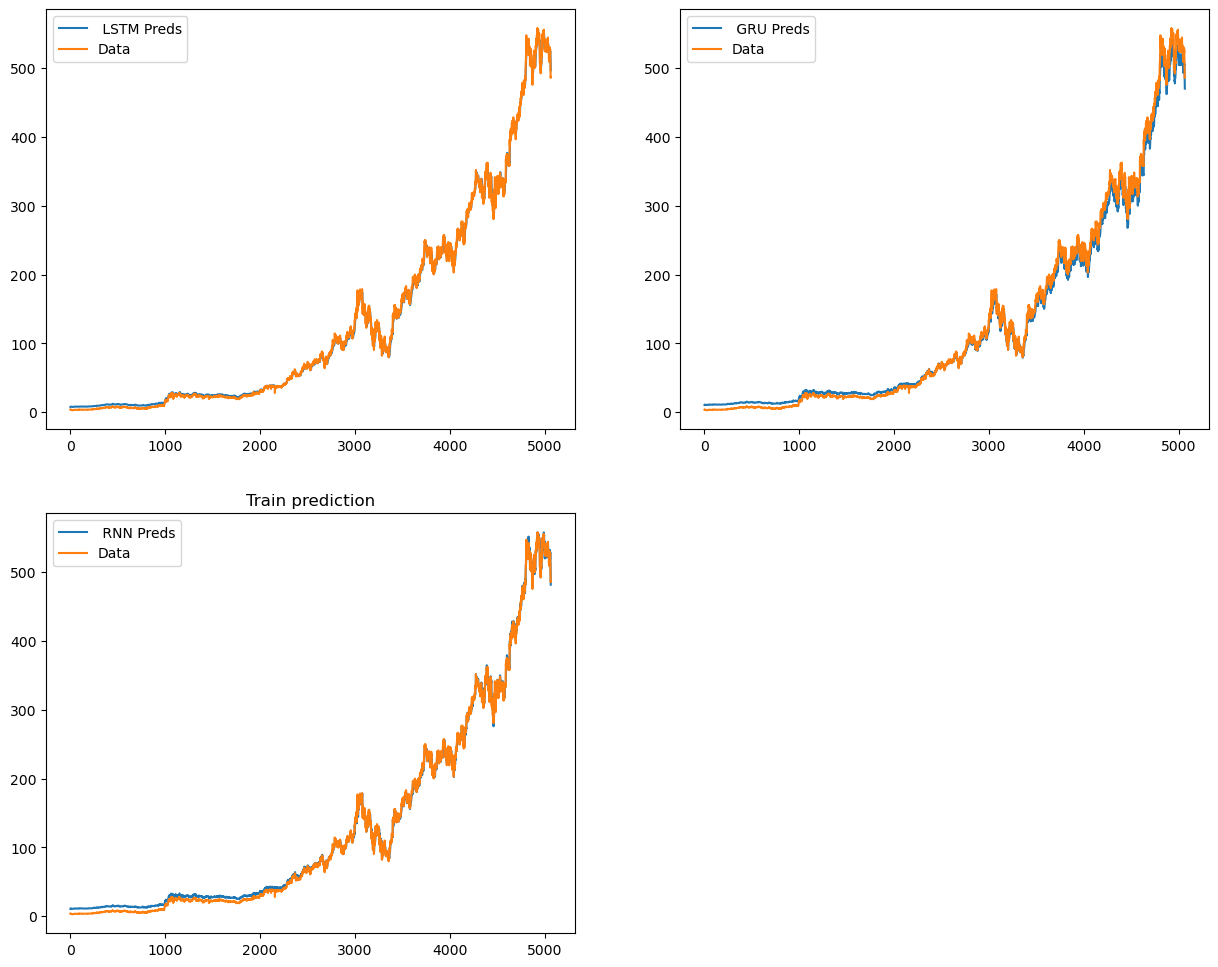

In [172]:
pred_value1 = y_train_pred1.detach().numpy()[:,-1]       
true_value1 = y_train_lstm.detach().numpy()[:,-1] 

# invert predictions
pred_value1 = scaler.inverse_transform(pred_value1.reshape(-1, 1))
true_value1 = scaler.inverse_transform(true_value1.reshape(-1, 1))

pred_value2 = y_train_pred2.detach().numpy()[:,-1]       
true_value2 = y_train_gru.detach().numpy()[:,-1] 
pred_value2 = scaler.inverse_transform(pred_value2.reshape(-1, 1))
true_value2 = scaler.inverse_transform(true_value2.reshape(-1, 1))

pred_value3 = y_train_pred3.detach().numpy()[:,-1]       
true_value3 = y_train_rnn.detach().numpy()[:,-1] 
pred_value3 = scaler.inverse_transform(pred_value3.reshape(-1, 1))
true_value3 = scaler.inverse_transform(true_value3.reshape(-1, 1))

plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
plt.plot(pred_value1, label=" LSTM Preds")    
plt.plot(true_value1, label="Data")           
plt.legend()

plt.subplot(2,2,2)
plt.plot(pred_value2, label=" GRU Preds")    
plt.plot(true_value2, label="Data")          
plt.legend()

plt.subplot(2,2,3)
plt.plot(pred_value3, label=" RNN Preds")    
plt.plot(true_value3, label="Data")          
plt.legend()

plt.title("Train prediction")
plt.show()

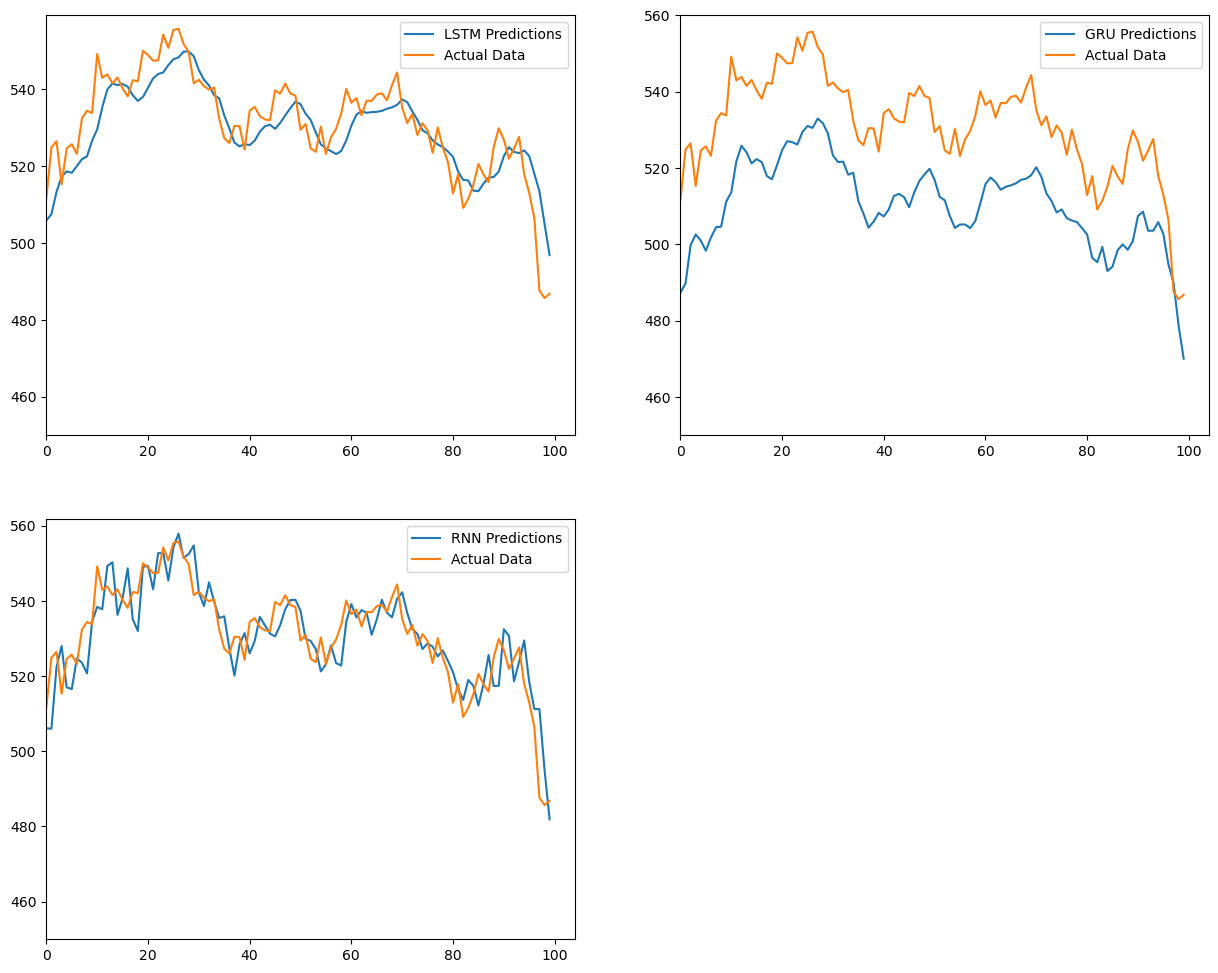

In [173]:
## check last 100 days train prediction
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
plt.plot(pred_value1[-100:], label="LSTM Predictions")    
plt.plot(true_value1[-100:], label="Actual Data")           
plt.legend()
plt.xlim(0)
plt.ylim(450)

plt.subplot(2,2,2)
plt.plot(pred_value2[-100:], label="GRU Predictions")    
plt.plot(true_value2[-100:], label="Actual Data")          
plt.legend()
plt.xlim(0)
plt.ylim(450)

plt.subplot(2,2,3)
plt.plot(pred_value3[-100:], label="RNN Predictions")    
plt.plot(true_value3[-100:], label="Actual Data")          
plt.legend()
plt.xlim(0)
plt.ylim(450)

plt.show()

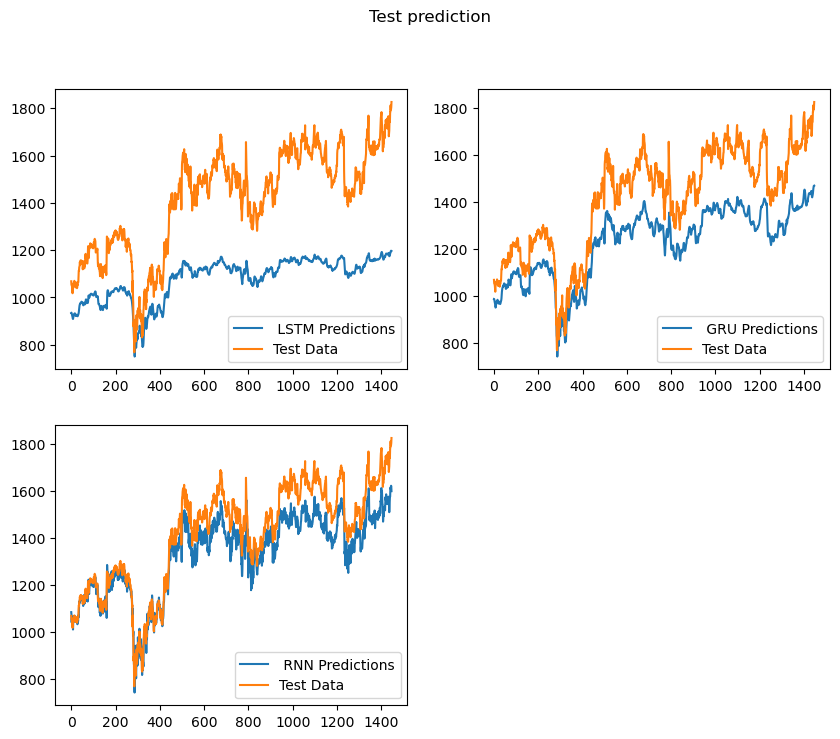

In [174]:
# Prediction on test data

pred_value1 = y_test_pred1.detach().numpy()[:,-1]    
true_value1 = y_test_lstm.detach().numpy()[:,-1]
pred_value1 = scaler.inverse_transform(pred_value1.reshape(-1, 1))
true_value1 = scaler.inverse_transform(true_value1.reshape(-1, 1))

pred_value2 = y_test_pred2.detach().numpy()[:,-1]       
true_value2 = y_test_gru.detach().numpy()[:,-1] 
pred_value2 = scaler.inverse_transform(pred_value2.reshape(-1, 1))
true_value2 = scaler.inverse_transform(true_value2.reshape(-1, 1))

pred_value3 = y_test_pred3.detach().numpy()[:,-1]       
true_value3 = y_test_rnn.detach().numpy()[:,-1] 
pred_value3 = scaler.inverse_transform(pred_value3.reshape(-1, 1))
true_value3 = scaler.inverse_transform(true_value3.reshape(-1, 1))

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(pred_value1, label=" LSTM Predictions")    
plt.plot(true_value1, label="Test Data")          
plt.legend()

plt.subplot(2,2,2)
plt.plot(pred_value2, label=" GRU Predictions")    
plt.plot(true_value2, label="Test Data")          
plt.legend()

plt.subplot(2,2,3)
plt.plot(pred_value3, label=" RNN Predictions")    
plt.plot(true_value3, label="Test Data")          
plt.legend()

plt.suptitle("Test prediction")
plt.show()

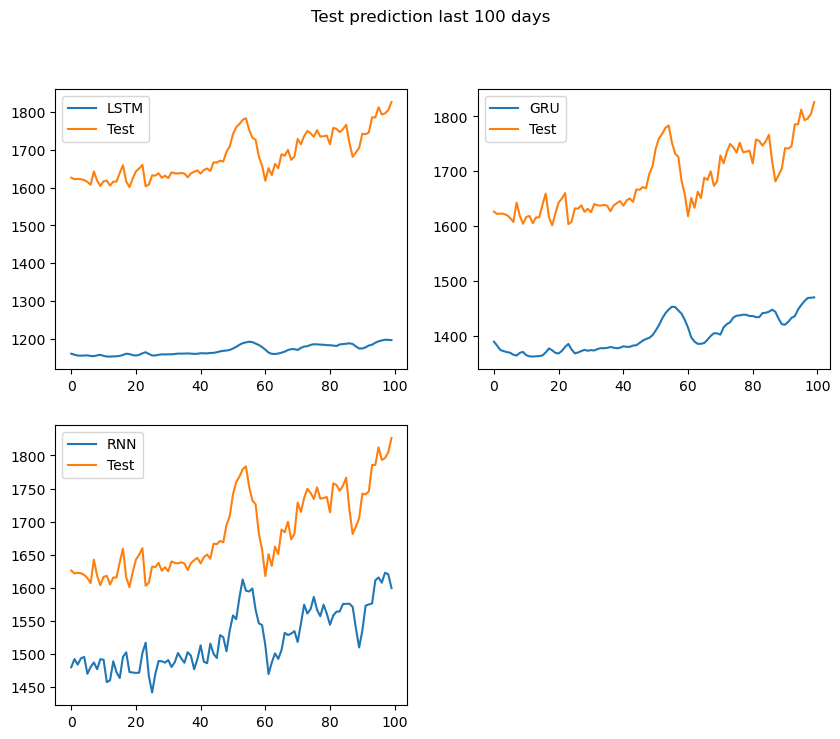

In [175]:
## check last 100 days test prediction
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(pred_value1[-100:], label="LSTM")    
plt.plot(true_value1[-100:], label="Test")           
plt.legend()

plt.subplot(2,2,2)
plt.plot(pred_value2[-100:], label="GRU")    
plt.plot(true_value2[-100:], label="Test")          
plt.legend()

plt.subplot(2,2,3)
plt.plot(pred_value3[-100:], label="RNN")    
plt.plot(true_value3[-100:], label="Test")         
plt.legend()

plt.suptitle("Test prediction last 100 days")
plt.show()

In [176]:
import torch
import numpy as np
import matplotlib.pyplot as plt


Training with sliding window 20...
Training model for sliding window 20...


c:\Users\Stewie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([5072, 4])) that is different to the input size (torch.Size([5072, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10, MSE: 0.016458794474601746
Epoch 20, MSE: 0.001777505618520081
Epoch 30, MSE: 0.002405912149697542
Epoch 40, MSE: 0.0006815947708673775
Epoch 50, MSE: 0.0003831721260212362
Epoch 60, MSE: 7.643273420399055e-05
Epoch 70, MSE: 4.009229814982973e-05
Epoch 80, MSE: 3.15352481266018e-05
Epoch 90, MSE: 2.3254469851963222e-05


c:\Users\Stewie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([725, 4])) that is different to the input size (torch.Size([725, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MSE for GRU with sliding window 20: 0.000633281480986625

Training with sliding window 50...
Training model for sliding window 50...


c:\Users\Stewie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([5051, 4])) that is different to the input size (torch.Size([5051, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10, MSE: 0.010856304317712784
Epoch 20, MSE: 0.0012987687950953841
Epoch 30, MSE: 0.0008425767300650477
Epoch 40, MSE: 0.0005220580496825278
Epoch 50, MSE: 0.00017809687415137887
Epoch 60, MSE: 7.634171197423711e-05
Epoch 70, MSE: 5.147728370502591e-05
Epoch 80, MSE: 4.149663800490089e-05
Epoch 90, MSE: 3.462295717326924e-05


c:\Users\Stewie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([722, 4])) that is different to the input size (torch.Size([722, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MSE for GRU with sliding window 50: 0.0006364452419802547

Training with sliding window 80...
Training model for sliding window 80...


c:\Users\Stewie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([5030, 4])) that is different to the input size (torch.Size([5030, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10, MSE: 0.004584046080708504
Epoch 20, MSE: 0.0022334919776767492
Epoch 30, MSE: 0.0006348349270410836
Epoch 40, MSE: 0.00018384015129413456
Epoch 50, MSE: 8.472502668155357e-05
Epoch 60, MSE: 6.111196125857532e-05
Epoch 70, MSE: 4.7340010496554896e-05
Epoch 80, MSE: 3.3361491659889e-05
Epoch 90, MSE: 2.3268121367436834e-05


c:\Users\Stewie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([719, 4])) that is different to the input size (torch.Size([719, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MSE for GRU with sliding window 80: 0.0019919362384825945

Training with sliding window 100...
Training model for sliding window 100...


c:\Users\Stewie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([5016, 4])) that is different to the input size (torch.Size([5016, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10, MSE: 0.006455841474235058
Epoch 20, MSE: 0.0014367877738550305
Epoch 30, MSE: 0.00013922729704063386
Epoch 40, MSE: 0.0002474915818311274
Epoch 50, MSE: 0.00015027759945951402
Epoch 60, MSE: 7.90112535469234e-05
Epoch 70, MSE: 4.976891432306729e-05
Epoch 80, MSE: 3.543663115124218e-05
Epoch 90, MSE: 2.8861977625638247e-05
Test MSE for GRU with sliding window 100: 0.0015783904818817973


c:\Users\Stewie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([717, 4])) that is different to the input size (torch.Size([717, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


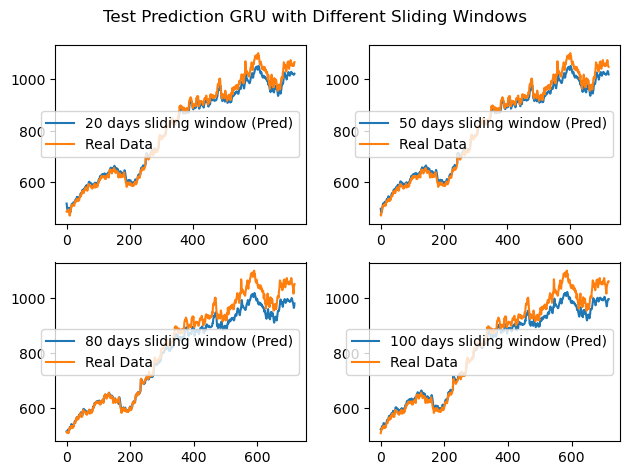

In [177]:
# Function to prepare data
def prepare_data(df, seq_length):
    x_train, y_train, x_test, y_test,x_val,y_val = split_data(df, seq_length)
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)
    return x_train, y_train, x_test, y_test, x_val,y_val

# Function to train GRU model
def train_gru_model(model_GRU, x_train, y_train, num_epochs, learning_rate=0.01):
    optimiser = torch.optim.Adam(model_GRU.parameters(), lr=learning_rate)
    hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        y_train_pred = model_GRU(x_train)
        loss = loss_fn(y_train_pred, y_train)
        
        if t % 10 == 0 and t != 0:
            print(f"Epoch {t}, MSE: {loss.item()}")
        hist[t] = loss.item()
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    return hist

# Function to evaluate GRU model
def evaluate_gru_model(model_GRU, x_test, y_test):
    y_test_pred = model_GRU(x_test)
    test_loss = loss_fn(y_test_pred, y_test).item()
    return y_test_pred, test_loss

# Function to plot predictions
def plot_predictions(pred_value, true_value, window_size):
    pred_value = scaler.inverse_transform(pred_value.reshape(-1, 1))
    true_value = scaler.inverse_transform(true_value.reshape(-1, 1))
    
    plt.plot(pred_value, label=f"{window_size} days sliding window (Pred)")
    plt.plot(true_value, label="Real Data")
    plt.legend()

# List of sliding window sizes to experiment with
window_sizes = [20,50,80,100]

# Train and evaluate models with different sliding window sizes
for seq in window_sizes:
    print(f"\nTraining with sliding window {seq}...")
    # Prepare data
    x_train, y_train, x_test, y_test,x_val,y_val = prepare_data(df_main, seq)
    
    # Train GRU model
    print(f"Training model for sliding window {seq}...")
    hist = train_gru_model(model_GRU, x_train, y_train, num_epochs)
    
    y_test_pred, test_loss = evaluate_gru_model(model_GRU, x_test, y_test)
    print(f"Test MSE for GRU with sliding window {seq}: {test_loss}")

    plt.subplot(2, 2, window_sizes.index(seq) + 1)
    plot_predictions(y_test_pred.detach().numpy()[:, -1], y_test.detach().numpy()[:, -1], seq)

plt.suptitle("Test Prediction GRU with Different Sliding Windows")
plt.tight_layout()
plt.show()
